In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import annotations
import numpy as np

from mflex.simulate.simulate_boundary import dalmatian

from mhsflex.field2d import Field2dData, check_fluxbalance, alpha_HS04
from mhsflex.vis import plot, plot_plasma_parameters, show_poles, show_footpoints
from mhsflex.metrics import compare_field3d

from matplotlib import rc, colors
import matplotlib.pyplot as plt
from scipy.io import readsav

import mhsflex.fluxbalance


rc("font", **{"family": "serif", "serif": ["Times"]})
rc("text", usetex=True)

cmap = colors.LinearSegmentedColormap.from_list(
    "cmap",
    (
        (0.000, (0.000, 0.000, 0.000)),
        (0.500, (0.659, 0.659, 0.659)),
        (1.000, (1.000, 1.000, 1.000)),
    ),
)

cmap2 = colors.LinearSegmentedColormap.from_list(
    "cmap2", ((0.000, (0.984, 1.000, 0.000)), (1.000, (1.000, 0.988, 0.761)))
)

c1 = (0.439, 0.788, 1.000)
c2 = (0.420, 0.502, 1.000)
c3 = "black"
c4 = (1.000, 0.224, 0.376)
c5 = (0.784, 0.231, 0.576)
c7 = (0.992, 0.251, 0.733)
c8 = (0.867, 0.871, 0.184)
c9 = (0.949, 0.922, 0.678)
c10 = (0.984, 0.455, 0.231)
c11 = (0.765, 0.835, 0.922)
c12 = (0.965, 0.694, 0.486)
c13 = (0.992, 0.584, 0.820)

/Users/lilli/Library/Caches/pypoetry/virtualenvs/mflex-cNoQEf_u-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = "/Users/lilli/Desktop/mflex/data/Analytic_boundary_data.sav"

data = readsav(path, python_dict=True, verbose=True)

--------------------------------------------------
Date: Tue Sep  6 15:16:46 2022
User: xszhu
Host: HR30
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: linux
IDL Version: 7.1.1
--------------------------------------------------
Successfully read 33 records of which:
 - 1 are of type TIMESTAMP
 - 29 are of type VARIABLE
 - 1 are of type VERSION
 - 1 are of type NOTICE
--------------------------------------------------
Available variables:
 - b2dx1 [<class 'numpy.ndarray'>]
 - b2dy1 [<class 'numpy.ndarray'>]
 - b2dz1 [<class 'numpy.ndarray'>]
 - d2d1 [<class 'numpy.ndarray'>]
 - b2dx2 [<class 'numpy.ndarray'>]
 - b2dy2 [<class 'numpy.ndarray'>]
 - b2dz2 [<class 'numpy.ndarray'>]
 - d2d2 [<class 'numpy.ndarray'>]
 - b2dx3 [<class 'numpy.ndarray'>]
 - b2dy3 [<class 'numpy.ndarray'>]
 - b2dz3 [<class 'numpy.ndarray'>]
 - d2d3 [<class 'numpy.ndarray'>]
 - b2dx4 [<class 'numpy.ndarray'>]
 - b2dy4 [<class 'numpy.ndarray'>]
 - b2dz4 [<class '

In [4]:
data_bz = data["b2dz5"]
data_bx = data["b2dx5"]
data_by = data["b2dy5"]

nresol_x = data_bz.shape[1]
nresol_y = data_bz.shape[0]

pixelsize_z = 0.04  # Convert pixelsize from km into Mm
pixelsize_x = 0.04
pixelsize_y = 0.04

xmin = np.float64(0.0)  # Minimum value of x in data length scale, not in Mm
ymin = np.float64(0.0)  # Minimum value of y in data length scale, not in Mm
zmin = np.float64(0.0)  # Minimum value of z in data length scale, not in Mm

xmax = nresol_x * pixelsize_x
ymax = nresol_y * pixelsize_y

nresol_z = 50

zmax = nresol_z * pixelsize_z

z0 = zmax

nf_max = min(nresol_x, nresol_y)

print("xmax, ymax, zmax", xmax, ymax, zmax)
print("nresol_x, nresol_y, nresol_z", nresol_x, nresol_y, nresol_z)
print("pixelsize_x", pixelsize_x)
print("pixelsize_y", pixelsize_y)
print("pixelsize_z", pixelsize_z)

xmax, ymax, zmax 3.2 3.2 2.0
nresol_x, nresol_y, nresol_z 80 80 50
pixelsize_x 0.04
pixelsize_y 0.04
pixelsize_z 0.04


In [5]:
x_arr = np.arange(nresol_x) * xmax / (nresol_x - 1)
y_arr = np.arange(nresol_y) * ymax / (nresol_y - 1)
z_arr = np.arange(nresol_z) * zmax / (nresol_z - 1)
x_grid, y_grid = np.meshgrid(x_arr, y_arr)

In [6]:
data2d = Field2dData(
    nresol_x,
    nresol_y,
    nresol_z,
    nf_max,
    pixelsize_x,
    pixelsize_y,
    pixelsize_z,
    x_arr,
    y_arr,
    z_arr,
    data_bz,
)

In [7]:
L_X = 3.2
print("Flux-balanced if below 10% --", check_fluxbalance(data2d))
print(
    "Alpha calucated with Sakurai formula --",
    alpha_HS04(data_bx, data_by, data_bz) * nresol_x / L_X,
)

Flux-balanced if below 10% -- -2.996346e-08
Alpha calucated with Sakurai formula -- -0.946507416665554


## Field lines are shown for three different cases: 

(1) Low (1991) solution coded by L Nadol with a and alpha chosen as ISSI Reference model, kappa chosen to visually fit to ISSI Reference field  <br>
(2) Asymptotic N+W(2019) solution coded by L Nadol with parameters calculated from (1)  <br>
(3) ISSI Reference model // Low (1991) solution coded by T Wiegelmann / provided by X Zhu

In [8]:
alpha = alpha_HS04(data_bx, data_by, data_bz) * (nresol_x-1) / L_X

length_scale_x = nresol_x * pixelsize_x
length_scale_y = nresol_y * pixelsize_y

length_scale_x_norm = length_scale_x
length_scale_y_norm = length_scale_y

kx_arr = np.arange(nf_max) * 2.0 * np.pi / length_scale_x_norm  # [0:nf_max]
ky_arr = np.arange(nf_max) * 2.0 * np.pi / length_scale_y_norm  # [0:nf_max]
one_arr = 0.0 * np.arange(nf_max) + 1.0

ky_grid = np.outer(ky_arr, one_arr)  # [0:nf_max, 0:nf_max]
kx_grid = np.outer(one_arr, kx_arr)  # [0:nf_max, 0:nf_max]

# kx^2 + ky^2

k2_arr = np.outer(ky_arr**2, one_arr) + np.outer(one_arr, kx_arr**2)
k2_arr[0, 0] = (np.pi * 2.0 / length_scale_x_norm) ** 2 + (
    np.pi * 2.0 / length_scale_y_norm
) ** 2

# Need k^2 > alpha^2/(1-2a) and k^2 > alpha^2

limit = (k2_arr - alpha**2) / (2 * k2_arr)

amax = limit.min()

print(amax, alpha)

0.386699330643024 -0.9346760739572346


In [9]:
KAPPA_X = 0.02
kappa = KAPPA_X/L_X
print(kappa)

0.0062499999999999995


# Meine eigene Low Lösung

In [10]:
kappa = 0.4
a = 0.5
alpha = -0.9346760739572346
data3dL = mhsflex.fluxbalance.calculate_magfield(data2d, a, 1.0, alpha, z0, kappa, asymptotic=False, tanh=False)

<built-in method min of numpy.ndarray object at 0x3046bed30>


In [11]:
sinks = data3dL.field[:, :, 0,2].copy()
sources = data3dL.field[:, :, 0,2].copy()

maxmask = sources < sources.max() * 0.4
sources[maxmask != 0] = 0

minmask = sinks < sinks.min() * 0.4
sinks[minmask == 0] = 0

In [12]:
c2 = (0.992, 0.251, 0.733)
from msat.pyvis.fieldline3d import fieldline3d

In [13]:
folder = "/Users/lilli/Desktop/Thesis/ISSI_SA/Part2"
b= 1.0

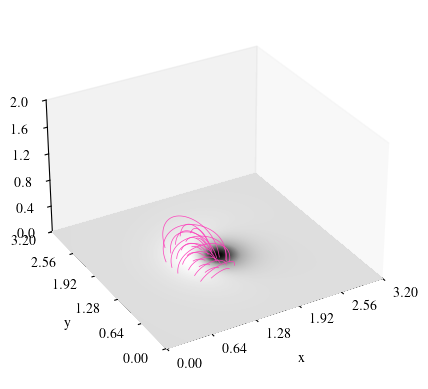

In [14]:
x_grid, y_grid = np.meshgrid(x_arr, y_arr)

fig = plt.figure()
ax = fig.figure.add_subplot(111, projection="3d")
ax.contourf(
    x_grid,
    y_grid,
    data3dL.field[:, :, 0,2],
    1000,
    # norm=norm,
    cmap=cmap,
    offset=0.0,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")  # type: ignore
ax.grid(False)
ax.set_zlim(zmin, zmax)  # type: ignore
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_box_aspect((xmax, ymax, zmax))  # type : ignore # (xmax, ymax, 2 * data.z0)

ax.xaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.xaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.yaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.yaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.zaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.zaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore

[t.set_va("center") for t in ax.get_yticklabels()]  # type : ignore
[t.set_ha("center") for t in ax.get_yticklabels()]  # type : ignore

[t.set_va("top") for t in ax.get_xticklabels()]  # type : ignore
[t.set_ha("center") for t in ax.get_xticklabels()]  # type : ignore

[t.set_va("center") for t in ax.get_zticklabels()]  # type : ignore
[t.set_ha("center") for t in ax.get_zticklabels()]  # type : ignore

h1 = 1.0 / 100.0  # Initial step length for fieldline3D
eps = 1.0e-8
# Tolerance to which we require point on field line known for fieldline3D
hmin = 0.0  # Minimum step length for fieldline3D
hmax = 1.0  # Maximum step length for fieldline3D

# Limit fieldline plot to original data size (rather than Seehafer size)
boxedges = np.zeros((2, 3))

# # Y boundaries must come first, X second due to switched order explained above
boxedges[0, 0] = ymin
boxedges[1, 0] = ymax
boxedges[0, 1] = xmin
boxedges[1, 1] = xmax
boxedges[0, 2] = zmin
boxedges[1, 2] = zmax

for ix in range(0, data3dL.field.shape[1], int(data3dL.field.shape[1] / 20)):
        for iy in range(0, data3dL.field.shape[0], int(data3dL.field.shape[0] / 20)):
            if sources[iy, ix] != 0 : #or sinks[iy, ix] != 0:

                x_start = ix / (nresol_x / xmax)
                y_start = iy / (nresol_y / ymax)

# x_0 = 0.0
# y_0 = 0.0
# dx = xmax / 10
# dy = ymax / 10

# nlinesmaxx = int(np.floor(xmax / dx))
# nlinesmaxy = int(np.floor(ymax / dy))

# for ilinesx in range(0, nlinesmaxx):
#         for ilinesy in range(0, nlinesmaxy):
#             x_start = x_0 + dx * ilinesx
#             y_start = y_0 + dy * ilinesy
            
                if data3dL.field[int(y_start), int(x_start), 0,2] < 0.0:
                    h1 = -h1

                ystart = [y_start, x_start, 0.0]

                fieldline = fieldline3d(
                    ystart,
                    data3dL.field,
                    y_arr,
                    x_arr,
                    data3dL.z,
                    h1,
                    hmin,
                    hmax,
                    eps,
                    oneway=False,
                    boxedge=boxedges,
                    gridcoord=False,
                    coordsystem="cartesian",
                )  # , periodicity='xy')

                if np.isclose(fieldline[:, 2][-1], 0.0) and np.isclose(
                    fieldline[:, 2][0], 0.0
                ):
                    # Need to give row direction first/ Y, then column direction/ X
                    ax.plot(
                        fieldline[:, 1],
                        fieldline[:, 0],
                        fieldline[:, 2],
                        color=c2,
                        linewidth=0.5,
                        zorder=4000,
                    )
                else:
                    ax.plot(
                        fieldline[:, 1],
                        fieldline[:, 0],
                        fieldline[:, 2],
                        color=c2,
                        linewidth=0.5,
                        zorder=4000,
                    )  # 2 * data.z0  # FOR ZOOM

## SIDE

# ax.view_init(0, -90)  # type: ignore

# ax.set_xlabel("x", labelpad=10)
# ax.set_ylabel("y", labelpad=10)

# ax.set_xticks(np.arange(0, xmax + 1.0 * 10**-8, xmax / 5))
# ax.set_yticks(np.arange(0, ymax + 1.0 * 10**-8, ymax / 5))


# [t.set_va("center") for t in ax.get_yticklabels()]  # type: ignore
# [t.set_ha("center") for t in ax.get_yticklabels()]  # type: ignore

# [t.set_va("center") for t in ax.get_xticklabels()]  # type: ignore
# [t.set_ha("center") for t in ax.get_xticklabels()]  # type: ignore

# ax.view_init(0, -90)  # type: ignore
# ax.set_xlabel("x", labelpad=5)
# ax.set_zlabel("z", labelpad=10)  # type: ignore

# ax.set_xticks(np.arange(0, xmax + 1.0 * 10**-8, xmax / 5))
# ax.set_zticks(np.arange(0, zmax + 1.0 * 10**-8, zmax / 5))  # type: ignore

# ax.set_yticklabels([])  # type: ignore
# ax.set_ylabel("")

# [t.set_va("center") for t in ax.get_xticklabels()]  # type: ignore
# [t.set_ha("center") for t in ax.get_xticklabels()]  # type: ignore

# [t.set_va("center") for t in ax.get_zticklabels()]  # type: ignore
# [t.set_ha("center") for t in ax.get_zticklabels()]  # type: ignore

## LOS

# ax.view_init(90, -90)  # type: ignore

# ax.set_xlabel("x", labelpad=10)
# ax.set_ylabel("y", labelpad=10)

# ax.set_xticks(np.arange(0, xmax + 1.0 * 10**-8, xmax / 5))
# ax.set_yticks(np.arange(0, ymax + 1.0 * 10**-8, ymax / 5))

# ax.set_zticklabels([])  # type: ignore
# ax.set_zlabel("")  # type: ignore

# [t.set_va("center") for t in ax.get_yticklabels()]  # type: ignore
# [t.set_ha("center") for t in ax.get_yticklabels()]  # type: ignore

# [t.set_va("center") for t in ax.get_xticklabels()]  # type: ignore
# [t.set_ha("center") for t in ax.get_xticklabels()]  # type: ignore

## ANGULAR

ax.view_init(30, 240, 0)  # type: ignore

ax.set_xticks(np.arange(0, xmax + 1.0 * 10**-8, xmax / 5))
ax.set_yticks(np.arange(0, ymax + 1.0 * 10**-8, ymax / 5))
ax.set_zticks(np.arange(0, zmax + 1.0 * 10**-8, zmax / 5))  # type: ignore

[t.set_va("bottom") for t in ax.get_yticklabels()]  # type: ignore
[t.set_ha("right") for t in ax.get_yticklabels()]  # type: ignore

[t.set_va("bottom") for t in ax.get_xticklabels()]  # type: ignore
[t.set_ha("left") for t in ax.get_xticklabels()]  # type: ignore

[t.set_va("top") for t in ax.get_zticklabels()]  # type: ignore
[t.set_ha("center") for t in ax.get_zticklabels()]  # type: ignore

plotname = (
    folder 
    + "/fieldlines_"
    + str(a)
    + "_"
    + str(alpha)
    + "_"
    + str(b)
    + "_angular.png"
)

plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)

# N+W (2019) Asymptotische Lösung

In [15]:
from mhsflex.switch import f, f_low

kappa = 0.4
a = 0.5
z0 = 2.0

f_exp = f_low(z_arr, a, kappa)

deltaz = 0.2

b = (np.exp(-kappa * z0) - 1) / (np.exp(-kappa * z0) * np.tanh(-z0 / deltaz))
aN = a / (1 - b * np.tanh(-z0 / deltaz))

f_tanh = f(z_arr, z0, deltaz, aN, b)

print(aN, b)

0.2246644820586108 1.225540933544524


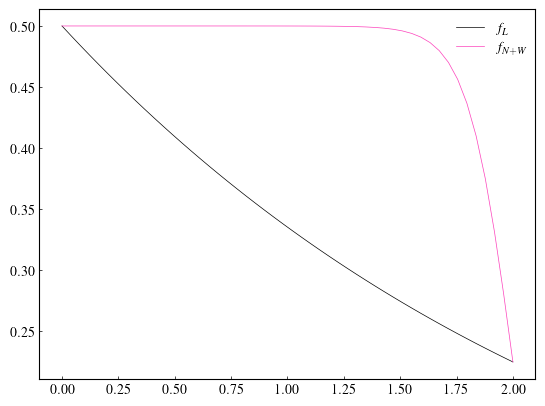

In [16]:
fig, ax1 = plt.subplots()

ax1.plot(
    z_arr,
    f_exp,
    label=r"$f_L$",
    linewidth=0.5,
    color="black",
    linestyle="solid",
)
ax1.plot(
    z_arr,
    f_tanh,
    label=r"$f_{N+W}$",
    linewidth=0.5,
    color=c2,
    linestyle="solid",
)
plt.legend(frameon=False)
# ax1.set_xlabel("z")
ax1.tick_params(direction="in", length=2, width=0.5)
# ax2.tick_params(direction="in", length=2, width=0.5)
plt.show()

In [17]:
alpha = -0.9346760739572346
data3dNW = mhsflex.fluxbalance.calculate_magfield(data2d, aN, b, alpha, z0, deltaz)

<built-in method min of numpy.ndarray object at 0x308b4d8f0>


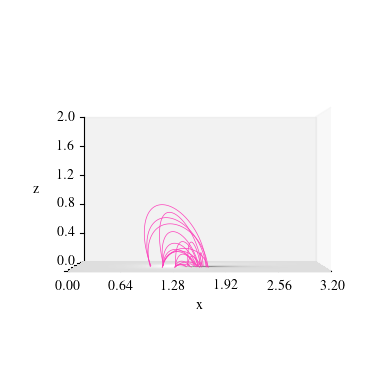

In [18]:
x_grid, y_grid = np.meshgrid(x_arr, y_arr)

fig = plt.figure()
ax = fig.figure.add_subplot(111, projection="3d")
ax.contourf(
    x_grid,
    y_grid,
    data3dNW.field[:, :, 0,2],
    1000,
    # norm=norm,
    cmap=cmap,
    offset=0.0,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")  # type: ignore
ax.grid(False)
ax.set_zlim(zmin, zmax)  # type: ignore
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_box_aspect((xmax, ymax, zmax))  # type : ignore # (xmax, ymax, 2 * data.z0)

ax.xaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.xaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.yaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.yaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.zaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.zaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore

[t.set_va("center") for t in ax.get_yticklabels()]  # type : ignore
[t.set_ha("center") for t in ax.get_yticklabels()]  # type : ignore

[t.set_va("top") for t in ax.get_xticklabels()]  # type : ignore
[t.set_ha("center") for t in ax.get_xticklabels()]  # type : ignore

[t.set_va("center") for t in ax.get_zticklabels()]  # type : ignore
[t.set_ha("center") for t in ax.get_zticklabels()]  # type : ignore

h1 = 1.0 / 100.0  # Initial step length for fieldline3D
eps = 1.0e-8
# Tolerance to which we require point on field line known for fieldline3D
hmin = 0.0  # Minimum step length for fieldline3D
hmax = 1.0  # Maximum step length for fieldline3D

# Limit fieldline plot to original data size (rather than Seehafer size)
boxedges = np.zeros((2, 3))

# # Y boundaries must come first, X second due to switched order explained above
boxedges[0, 0] = ymin
boxedges[1, 0] = ymax
boxedges[0, 1] = xmin
boxedges[1, 1] = xmax
boxedges[0, 2] = zmin
boxedges[1, 2] = zmax

for ix in range(0, data3dNW.field.shape[1], int(data3dNW.field.shape[1] / 20)):
        for iy in range(0, data3dNW.field.shape[0], int(data3dNW.field.shape[0] / 20)):
            if sources[iy, ix] != 0 : #or sinks[iy, ix] != 0:

                x_start = ix / (nresol_x / xmax)
                y_start = iy / (nresol_y / ymax)

# x_0 = 0.0
# y_0 = 0.0
# dx = xmax / 10
# dy = ymax / 10

# nlinesmaxx = int(np.floor(xmax / dx))
# nlinesmaxy = int(np.floor(ymax / dy))

# for ilinesx in range(0, nlinesmaxx):
#         for ilinesy in range(0, nlinesmaxy):
#             x_start = x_0 + dx * ilinesx
#             y_start = y_0 + dy * ilinesy
            
                if data3dNW.field[int(y_start), int(x_start), 0,2] < 0.0:
                    h1 = -h1

                ystart = [y_start, x_start, 0.0]

                fieldline = fieldline3d(
                    ystart,
                    data3dNW.field,
                    y_arr,
                    x_arr,
                    data3dNW.z,
                    h1,
                    hmin,
                    hmax,
                    eps,
                    oneway=False,
                    boxedge=boxedges,
                    gridcoord=False,
                    coordsystem="cartesian",
                )  # , periodicity='xy')

                if np.isclose(fieldline[:, 2][-1], 0.0) and np.isclose(
                    fieldline[:, 2][0], 0.0
                ):
                    # Need to give row direction first/ Y, then column direction/ X
                    ax.plot(
                        fieldline[:, 1],
                        fieldline[:, 0],
                        fieldline[:, 2],
                        color=c2,
                        linewidth=0.5,
                        zorder=4000,
                    )
                else:
                    ax.plot(
                        fieldline[:, 1],
                        fieldline[:, 0],
                        fieldline[:, 2],
                        color=c2,
                        linewidth=0.5,
                        zorder=4000,
                    )  # 2 * data.z0  # FOR ZOOM

## SIDE

ax.view_init(0, -90)  # type: ignore

ax.set_xlabel("x", labelpad=10)
ax.set_ylabel("y", labelpad=10)

ax.set_xticks(np.arange(0, xmax + 1.0 * 10**-8, xmax / 5))
ax.set_yticks(np.arange(0, ymax + 1.0 * 10**-8, ymax / 5))


[t.set_va("center") for t in ax.get_yticklabels()]  # type: ignore
[t.set_ha("center") for t in ax.get_yticklabels()]  # type: ignore

[t.set_va("center") for t in ax.get_xticklabels()]  # type: ignore
[t.set_ha("center") for t in ax.get_xticklabels()]  # type: ignore

ax.view_init(0, -90)  # type: ignore
ax.set_xlabel("x", labelpad=5)
ax.set_zlabel("z", labelpad=10)  # type: ignore

ax.set_xticks(np.arange(0, xmax + 1.0 * 10**-8, xmax / 5))
ax.set_zticks(np.arange(0, zmax + 1.0 * 10**-8, zmax / 5))  # type: ignore

ax.set_yticklabels([])  # type: ignore
ax.set_ylabel("")

[t.set_va("center") for t in ax.get_xticklabels()]  # type: ignore
[t.set_ha("center") for t in ax.get_xticklabels()]  # type: ignore

[t.set_va("center") for t in ax.get_zticklabels()]  # type: ignore
[t.set_ha("center") for t in ax.get_zticklabels()]  # type: ignore

## LOS

# ax.view_init(90, -90)  # type: ignore

# ax.set_xlabel("x", labelpad=10)
# ax.set_ylabel("y", labelpad=10)

# ax.set_xticks(np.arange(0, xmax + 1.0 * 10**-8, xmax / 5))
# ax.set_yticks(np.arange(0, ymax + 1.0 * 10**-8, ymax / 5))

# ax.set_zticklabels([])  # type: ignore
# ax.set_zlabel("")  # type: ignore

# [t.set_va("center") for t in ax.get_yticklabels()]  # type: ignore
# [t.set_ha("center") for t in ax.get_yticklabels()]  # type: ignore

# [t.set_va("center") for t in ax.get_xticklabels()]  # type: ignore
# [t.set_ha("center") for t in ax.get_xticklabels()]  # type: ignore

## ANGULAR

# ax.view_init(30, 240, 0)  # type: ignore

# ax.set_xticks(np.arange(0, xmax + 1.0 * 10**-8, xmax / 5))
# ax.set_yticks(np.arange(0, ymax + 1.0 * 10**-8, ymax / 5))
# ax.set_zticks(np.arange(0, zmax + 1.0 * 10**-8, zmax / 5))  # type: ignore

# [t.set_va("bottom") for t in ax.get_yticklabels()]  # type: ignore
# [t.set_ha("right") for t in ax.get_yticklabels()]  # type: ignore

# [t.set_va("bottom") for t in ax.get_xticklabels()]  # type: ignore
# [t.set_ha("left") for t in ax.get_xticklabels()]  # type: ignore

# [t.set_va("top") for t in ax.get_zticklabels()]  # type: ignore
# [t.set_ha("center") for t in ax.get_zticklabels()]  # type: ignore

plotname = (
    folder 
    + "/fieldlines_NWA_"
    + str(a)
    + "_"
    + str(alpha)
    + "_"
    + str(b)
    + "_side.png"
)

plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)

# Plot ISSI Semi-analytical Low and Lou BC with Low extrapolation without using Seehafer

In [19]:
path3dref = "/Users/lilli/Desktop/mflex/data/Analytic_3D_data.sav"
data3dref = readsav(path3dref, python_dict=True, verbose=True)

bx_ref = data3dref["b3dx"]
by_ref = data3dref["b3dy"]
bz_ref = data3dref["b3dz"]

presref = data3dref["p3d"] * 10**-1
denref = data3dref["d3d"] * 10**3

issi_bx = np.zeros((nresol_y, nresol_x, nresol_z))
issi_by = np.zeros_like(issi_bx)
issi_bz = np.zeros_like(issi_bx)

for i in range(0, nresol_y):
    for j in range(0, nresol_x):
        for k in range(0, nresol_z):
            issi_bx[i, j, k] = bx_ref[k, i, j]
            issi_by[i, j, k] = by_ref[k, i, j]
            issi_bz[i, j, k] = bz_ref[k, i, j]

B_ref = np.zeros((nresol_y, nresol_x, nresol_z, 3))

B_ref[:, :, :, 0] = issi_by[:,:,:]
B_ref[:, :, :, 1] = issi_bx[:,:,:]
B_ref[:, :, :, 2] = issi_bz[:,:,:]

--------------------------------------------------
Date: Tue Sep  6 15:11:11 2022
User: xszhu
Host: HR30
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: linux
IDL Version: 7.1.1
--------------------------------------------------
Successfully read 12 records of which:
 - 1 are of type TIMESTAMP
 - 8 are of type VARIABLE
 - 1 are of type VERSION
 - 1 are of type NOTICE
--------------------------------------------------
Available variables:
 - b3dx [<class 'numpy.ndarray'>]
 - b3dy [<class 'numpy.ndarray'>]
 - b3dz [<class 'numpy.ndarray'>]
 - p3d [<class 'numpy.ndarray'>]
 - d3d [<class 'numpy.ndarray'>]
 - info_unit [<class 'bytes'>]
 - info_pixel [<class 'bytes'>]
 - info_array [<class 'bytes'>]
--------------------------------------------------


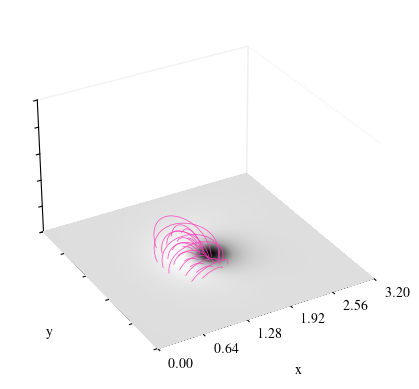

In [20]:
fig = plt.figure()
ax = fig.figure.add_subplot(111, projection="3d")
ax.contourf(
    x_grid,
    y_grid,
    B_ref[:, :, 0,2],
    1000,
    # norm=norm,
    cmap=cmap,
    offset=0.0,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")  # type: ignore
ax.grid(False)
ax.set_zlim(zmin, zmax)  # type: ignore
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_box_aspect((xmax, ymax, zmax))  # type : ignore # (xmax, ymax, 2 * data.z0)

ax.xaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.xaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.yaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.yaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore
ax.zaxis._axinfo["tick"]["inward_factor"] = 0.2  # type : ignore
ax.zaxis._axinfo["tick"]["outward_factor"] = 0  # type : ignore

ax.xaxis.pane.fill = False  # type : ignore
ax.yaxis.pane.fill = False  # type : ignore
ax.zaxis.pane.fill = False  # type : ignore

[t.set_va("center") for t in ax.get_yticklabels()]  # type : ignore
[t.set_ha("center") for t in ax.get_yticklabels()]  # type : ignore

[t.set_va("top") for t in ax.get_xticklabels()]  # type : ignore
[t.set_ha("center") for t in ax.get_xticklabels()]  # type : ignore

[t.set_va("center") for t in ax.get_zticklabels()]  # type : ignore
[t.set_ha("center") for t in ax.get_zticklabels()]  # type : ignore

h1 = 1.0 / 100.0  # Initial step length for fieldline3D
eps = 1.0e-8
# Tolerance to which we require point on field line known for fieldline3D
hmin = 0.0  # Minimum step length for fieldline3D
hmax = 1.0  # Maximum step length for fieldline3D

# Limit fieldline plot to original data size (rather than Seehafer size)
boxedges = np.zeros((2, 3))

# # Y boundaries must come first, X second due to switched order explained above
boxedges[0, 0] = ymin
boxedges[1, 0] = ymax
boxedges[0, 1] = xmin
boxedges[1, 1] = xmax
boxedges[0, 2] = zmin
boxedges[1, 2] = zmax

for ix in range(0, B_ref.shape[1], int(B_ref.shape[1] / 20)):
        for iy in range(0, B_ref.shape[0], int(B_ref.shape[0] / 20)):
            if sources[iy, ix] != 0: # or sinks[iy, ix] != 0:

                x_start = ix / (nresol_x / xmax)
                y_start = iy / (nresol_y / ymax)

# x_0 = 0.0
# y_0 = 0.0
# dx = xmax / 10
# dy = ymax / 10

# nlinesmaxx = int(np.floor(xmax / dx))
# nlinesmaxy = int(np.floor(ymax / dy))

# for ilinesx in range(0, nlinesmaxx):
#         for ilinesy in range(0, nlinesmaxy):
            
#             x_start = x_0 + dx * ilinesx
#             y_start = y_0 + dy * ilinesy
                if B_ref[int(y_start), int(x_start), 0,2] < 0.0:
                    h1 = -h1

                ystart = [y_start, x_start, 0.0]

                fieldline = fieldline3d(
                    ystart,
                    B_ref,
                    y_arr,
                    x_arr,
                    data3dL.z,
                    h1,
                    hmin,
                    hmax,
                    eps,
                    oneway=False,
                    boxedge=boxedges,
                    gridcoord=False,
                    coordsystem="cartesian",
                )  # , periodicity='xy')

                if np.isclose(fieldline[:, 2][-1], 0.0) and np.isclose(
                    fieldline[:, 2][0], 0.0
                ):
                    # Need to give row direction first/ Y, then column direction/ X
                    ax.plot(
                        fieldline[:, 1],
                        fieldline[:, 0],
                        fieldline[:, 2],
                        color=c2,
                        linewidth=0.5,
                        zorder=4000,
                    )
                else:
                    ax.plot(
                        fieldline[:, 1],
                        fieldline[:, 0],
                        fieldline[:, 2],
                        color=c2,
                        linewidth=0.5,
                        zorder=4000,
                    )  # 2 * data.z0  # FOR ZOOM

## SIDE

ax.view_init(0, -90)  # type: ignore

ax.set_xlabel("x", labelpad=10)
ax.set_ylabel("y", labelpad=10)

ax.set_xticks(np.arange(0, xmax + 1.0 * 10**-8, xmax / 5))
ax.set_yticks(np.arange(0, ymax + 1.0 * 10**-8, ymax / 5))


[t.set_va("center") for t in ax.get_yticklabels()]  # type: ignore
[t.set_ha("center") for t in ax.get_yticklabels()]  # type: ignore

[t.set_va("center") for t in ax.get_xticklabels()]  # type: ignore
[t.set_ha("center") for t in ax.get_xticklabels()]  # type: ignore

ax.view_init(0, -90)  # type: ignore
ax.set_xlabel("x", labelpad=5)
ax.set_zlabel("z", labelpad=10)  # type: ignore

ax.set_xticks(np.arange(0, xmax + 1.0 * 10**-8, xmax / 5))
ax.set_zticks(np.arange(0, zmax + 1.0 * 10**-8, zmax / 5))  # type: ignore

ax.set_yticklabels([])  # type: ignore
ax.set_ylabel("")

[t.set_va("center") for t in ax.get_xticklabels()]  # type: ignore
[t.set_ha("center") for t in ax.get_xticklabels()]  # type: ignore

[t.set_va("center") for t in ax.get_zticklabels()]  # type: ignore
[t.set_ha("center") for t in ax.get_zticklabels()]  # type: ignore

## LOS

ax.view_init(90, -90)  # type: ignore

ax.set_xlabel("x", labelpad=10)
ax.set_ylabel("y", labelpad=10)

ax.set_xticks(np.arange(0, xmax + 1.0 * 10**-8, xmax / 5))
ax.set_yticks(np.arange(0, ymax + 1.0 * 10**-8, ymax / 5))

ax.set_zticklabels([])  # type: ignore
ax.set_zlabel("")  # type: ignore

[t.set_va("center") for t in ax.get_yticklabels()]  # type: ignore
[t.set_ha("center") for t in ax.get_yticklabels()]  # type: ignore

[t.set_va("center") for t in ax.get_xticklabels()]  # type: ignore
[t.set_ha("center") for t in ax.get_xticklabels()]  # type: ignore

## ANGULAR

ax.view_init(30, 240, 0)  # type: ignore

ax.set_xticks(np.arange(0, xmax + 1.0 * 10**-8, xmax / 5))
ax.set_yticks(np.arange(0, ymax + 1.0 * 10**-8, ymax / 5))
ax.set_zticks(np.arange(0, zmax + 1.0 * 10**-8, zmax / 5))  # type: ignore

[t.set_va("bottom") for t in ax.get_yticklabels()]  # type: ignore
[t.set_ha("right") for t in ax.get_yticklabels()]  # type: ignore

[t.set_va("bottom") for t in ax.get_xticklabels()]  # type: ignore
[t.set_ha("left") for t in ax.get_xticklabels()]  # type: ignore

[t.set_va("top") for t in ax.get_zticklabels()]  # type: ignore
[t.set_ha("center") for t in ax.get_zticklabels()]  # type: ignore

plotname = (
    folder 
    + "/fieldlines_ISSI_"
    + str(a)
    + "_"
    + str(alpha)
    + "_"
    + str(b)
    + "_angular.png"
)

plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)

In [21]:
from mhsflex.metrics import VecCorr, CauSchw, NormErr, MeanErr, MagEnergy

In [22]:
print(VecCorr(B_ref, data3dL.field))
print(CauSchw(B_ref, data3dL.field))
print(NormErr(B_ref, data3dL.field))
print(MeanErr(B_ref, data3dL.field))
print(MagEnergy(B_ref, data3dL.field))



0.9960545430055974
0.998727547208554
0.06416231559415128
0.05105906197040921
0.9603946708679807


In [23]:
print(VecCorr(data3dL.field, data3dNW.field))
print(CauSchw(data3dL.field, data3dNW.field))
print(NormErr(data3dL.field, data3dNW.field))
print(MeanErr(data3dL.field, data3dNW.field))
print(MagEnergy(data3dL.field, data3dNW.field))

0.9978791150419626
0.9971736981776063
0.11862988163084215
0.22332340691243935
1.0318709624693887


In [24]:
print(VecCorr(B_ref, data3dNW.field))
print(CauSchw(B_ref, data3dNW.field))
print(NormErr(B_ref, data3dNW.field))
print(MeanErr(B_ref, data3dNW.field))
print(MagEnergy(B_ref, data3dNW.field))

0.9936637259948312
0.9953397232219134
0.14131460987306296
0.22714694761520876
0.9910033733790149


In [25]:
temps = np.array([6000.0, 5500.0, 10000.0])
heights = np.array([0.0, z0 / 4, z0])

from mhsflex.field3d import (
    bpressure_linear,
    bdensity_linear,
    btemp_linear,
    fpressure_linear,
    fdensity_linear,
)

backtemp = btemp_linear(data3dNW, heights, temps)
backpres = bpressure_linear(data3dNW, heights, temps)
backden = bdensity_linear(data3dNW, heights, temps)

In [26]:
T_PHOTOSPHERE = 6000.0  # Photospheric temperature
T_CORONA = 2.0 * 10.0**6  # Coronal temperature

G_SOLAR = 272.2  # m/s^2
KB = 1.380649 * 10**-23  # Boltzmann constant in Joule/ Kelvin = kg m^2/(Ks^2)
MBAR = 1.67262 * 10**-27  # mean molecular weight (proton mass)
RHO0 = 2.7 * 10**-4  # plasma density at z = 0 in kg/(m^3)

RHO0 = 9.0 * 10**-4

P0 = T_PHOTOSPHERE * KB * RHO0 / MBAR  # plasma pressure in kg/(s^2 m)
MU0 = 1.25663706 * 10**-6  # permeability of free space in mkg/(s^2A^2)

L = 10**6  # Lengthscale Mm
T0 = 10000.0
H = KB * T0 / (MBAR * G_SOLAR) / L
B0 = data2d.bz.max()  # Gauss background magnetic field strength in 10^-4 kg/(s^2A) = 10^-4 T
PB0 = (B0 * 10**-4) ** 2 / (2 * MU0)  # magnetic pressure b0**2 / 2mu0 in kg/(s^2m)
BETA0 = P0 / PB0  # Plasma Beta, ration plasma to magnetic pressure

In [27]:
maxcoord = np.unravel_index(
    np.argmax(data2d.bz, axis=None),
    data2d.bz.shape,
)
iy = int(maxcoord[0])
ix = int(maxcoord[1])

fpresL = fpressure_linear(data3dL, heights, temps)
fdenL = fdensity_linear(data3dL, heights, temps)

fpresNW = fpressure_linear(data3dNW, heights, temps)
fdenNW = fdensity_linear(data3dNW, heights, temps)

In [28]:
fpresISSI = np.zeros_like(fpresL)
fdenISSI = np.zeros_like(fpresL)

In [29]:
for i in range(0, nresol_y):
    for j in range(0, nresol_x):
        for k in range(0, nresol_z):
            fpresISSI[i, j, k] = presref[k, i, j]
            fdenISSI[i, j, k] = denref[k, i, j]

In [30]:
c2 = (0.420, 0.502, 1.000)

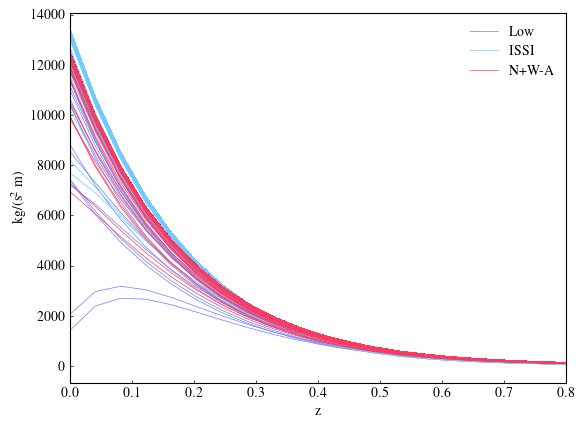

In [31]:
plt.plot(
    z_arr,
    fpresL[0, 0, :],
    linewidth=0.5,
    color=c2,
    label="Low"
)
plt.plot(
    z_arr,
    fpresISSI[0, 0, :],
    linewidth=0.5,
    color=c1,
    label="ISSI"
)
plt.plot(
    z_arr,
    fpresNW[0, 0, :],
    linewidth=0.5,
    color=c4,
    label="N+W-A",
    #linestyle=(5, (5,5))
)
for ix in range(1, nresol_x, 4):
    for iy in range(1, nresol_y, 4):
        # for ix in range(nresol_x):
        #     for iy in range(nresol_y):
        plt.plot(
            z_arr,
            fpresL[iy, ix, :],
            linewidth=0.5,
            color=c2,  # alpha=0.04
        )
for ix in range(1, nresol_x, 4):
    for iy in range(1, nresol_y, 4):
        plt.plot(
            z_arr,
            fpresISSI[iy, ix, :],
            linewidth=0.5,
            color=c1,
        )
for ix in range(1, nresol_x,4):
    for iy in range(1, nresol_y, 4):
        plt.plot(
            z_arr,
            fpresNW[iy, ix, :],
            linewidth=0.5,
            color=c4,
            #linestyle=(5, (5,5))
        )
plt.ylabel(r"kg/($\textrm{s}^2$ m)")
plt.xlabel("z")
plt.xlim([0, 0.8])
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/fpres_comp.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

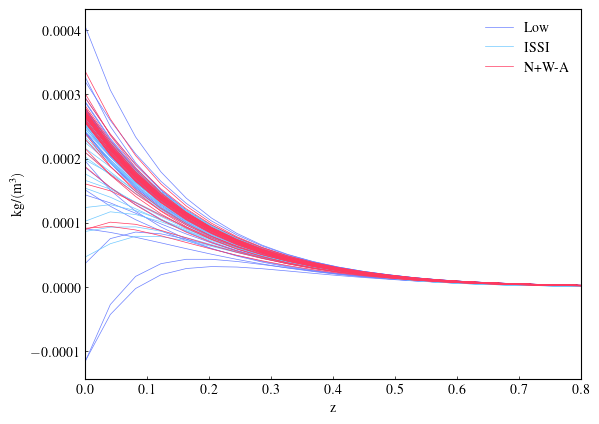

In [32]:
plt.plot(
    z_arr,
    fdenL[0, 0, :],
    linewidth=0.5,
    color=c2,
    label="Low"
)
plt.plot(
    z_arr,
    fdenISSI[0, 0, :],
    linewidth=0.5,
    color=c1,
    label="ISSI"
)
plt.plot(
    z_arr,
    fdenNW[0, 0, :],
    linewidth=0.5,
    color=c4,
    label="N+W-A",
    #linestyle=(5, (5,5))
)
for ix in range(1, nresol_x, 4):
    for iy in range(1, nresol_y, 4):
        # for ix in range(nresol_x):
        #     for iy in range(nresol_y):
        plt.plot(
            z_arr,
            fdenL[iy, ix, :],
            linewidth=0.5,
            color=c2,  # alpha=0.04
        )
for ix in range(1, nresol_x, 4):
    for iy in range(1, nresol_y, 4):
        plt.plot(
            z_arr,
            fdenISSI[iy, ix, :],
            linewidth=0.5,
            color=c1,
        )
for ix in range(1, nresol_x,4):
    for iy in range(1, nresol_y, 4):
        plt.plot(
            z_arr,
            fdenNW[iy, ix, :],
            linewidth=0.5,
            color=c4,
            #linestyle=(5, (5,5))
        )
plt.ylabel(r"kg/$(\textrm{m}^3)$")
plt.xlabel("z")
plt.xlim([0, 0.8])
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/fden_comp.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [33]:
from mhsflex.metrics import pearson_corr_coeff_issi, pearson_corr_coeff

In [34]:
pearson_corr_coeff_issi(fpresISSI, fdenISSI, data3dL, heights, temps)

Pearson Correlation reference value for pressure  PearsonRResult(statistic=1.0, pvalue=0.0)
Pearson Correlation reference value for density  PearsonRResult(statistic=1.0, pvalue=0.0)
Pearson Correlation actual value for pressure  PearsonRResult(statistic=0.9915069362502552, pvalue=0.0)
Pearson Correlation actual value for density  PearsonRResult(statistic=0.7686649980222737, pvalue=0.0)


In [35]:
pearson_corr_coeff_issi(fpresISSI, fdenISSI, data3dNW, heights, temps)

Pearson Correlation reference value for pressure  PearsonRResult(statistic=1.0, pvalue=0.0)
Pearson Correlation reference value for density  PearsonRResult(statistic=1.0, pvalue=0.0)
Pearson Correlation actual value for pressure  PearsonRResult(statistic=0.9922814459506567, pvalue=0.0)
Pearson Correlation actual value for density  PearsonRResult(statistic=0.7548272360162311, pvalue=0.0)


In [36]:
pearson_corr_coeff(data3dL, data3dNW)

Pearson Correlation reference value for pressure  PearsonRResult(statistic=1.0, pvalue=0.0)
Pearson Correlation reference value for density  PearsonRResult(statistic=1.0, pvalue=0.0)
Pearson Correlation actual value for pressure  PearsonRResult(statistic=0.9995550579808645, pvalue=0.0)
Pearson Correlation actual value for density  PearsonRResult(statistic=0.9996048287439594, pvalue=0.0)


(array([[1.46223282, 1.46222709, 1.46221767, ..., 1.46223494, 1.46223297,
         1.46223282],
        [1.46225269, 1.46224437, 1.46223329, ..., 1.4622618 , 1.4622566 ,
         1.46225269],
        [1.46227049, 1.46226042, 1.46224792, ..., 1.46228355, 1.46227631,
         1.46227049],
        ...,
        [1.46218922, 1.46219003, 1.46218395, ..., 1.46216087, 1.46216873,
         1.46218922],
        [1.46221042, 1.46220834, 1.46220067, ..., 1.46219167, 1.46219527,
         1.46221042],
        [1.46223282, 1.46222709, 1.46221767, ..., 1.46223494, 1.46223297,
         1.46223282]]),
 array([[7.9021301 , 7.90229189, 7.90232557, ..., 7.90192779, 7.90187296,
         7.9021301 ],
        [7.90223741, 7.90234487, 7.90236235, ..., 7.90218336, 7.90213908,
         7.90223741],
        [7.90228614, 7.90238217, 7.90238772, ..., 7.90219575, 7.90214257,
         7.90228614],
        ...,
        [7.90186987, 7.90224291, 7.90222975, ..., 7.90158765, 7.90127846,
         7.90186987],
        [7.9

In [52]:
from mhsflex.metrics import field_div_metric_fb, field_div_metric_issi

In [53]:
field_div_metric_fb(data3dL, data3dNW)

256 168 165


0.9821428571428571

In [54]:
field_div_metric_issi(B_ref, data3dNW)

256 169 141


0.834319526627219

In [55]:
field_div_metric_issi(B_ref, data3dL)

256 176 154


0.875